In [ ]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install opencv-python
!pip3 install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import re
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn 
import timm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import albumentations as A

In [2]:
# Path Constants
DATASET_IMAGES_PATH = './data/Images'
DATASET_LABELS_PATH = './data/Labels'

In [ ]:
# Path Constants
DATASET_IMAGES_PATH = './/drive//MyDrive//Images'
DATASET_LABELS_PATH = './/drive//MyDrive//Labels'

In [3]:
# Create a list of all the images and labels in the dataset
file_names = os.listdir(DATASET_IMAGES_PATH)
file_names_sorted = sorted(file_names)
images_df_sorted = pd.DataFrame({'image_name' : file_names_sorted})

file_names1 = os.listdir(DATASET_LABELS_PATH)
file_names1_sorted = sorted(file_names1)
labels_df_sorted = pd.DataFrame({'label_name' : file_names1_sorted})

In [4]:
images_df_sorted

,image_name
0,1.jpeg
1,10.jpeg
2,100.jpeg
3,101.jpeg
4,102.jpeg
...,...
328,95.jpeg
329,96.jpeg
330,97.jpeg
331,98.jpeg


In [5]:
labels_df_sorted

,label_name
0,1.txt
1,10.txt
2,100.txt
3,101.txt
4,102.txt
...,...
328,95.txt
329,96.txt
330,97.txt
331,98.txt


In [6]:
labeled_images_df = pd.merge(images_df_sorted, labels_df_sorted, left_index=True, right_index=True)
labeled_images_df

,image_name,label_name
0,1.jpeg,1.txt
1,10.jpeg,10.txt
2,100.jpeg,100.txt
3,101.jpeg,101.txt
4,102.jpeg,102.txt
...,...,...
328,95.jpeg,95.txt
329,96.jpeg,96.txt
330,97.jpeg,97.txt
331,98.jpeg,98.txt


In [7]:
labeled_images_df['count'] = np.nan
labeled_images_df['x1'] = np.nan
labeled_images_df['y1'] = np.nan
labeled_images_df['x2'] = np.nan
labeled_images_df['y2'] = np.nan

# Regex -> match numbers only
regex = re.compile(r'\d+')

for index, row in labeled_images_df.iterrows():
    label_file = open(os.path.join(DATASET_LABELS_PATH, row['label_name']), 'r')
    label_file_contents = label_file.read()
    label_file.close()
    
    label_file_contents = regex.findall(label_file_contents)
    label_file_contents = [int(i) for i in label_file_contents]
    
    labeled_images_df.loc[index, 'count'] = label_file_contents[0]
    labeled_images_df.loc[index, 'x1'] = label_file_contents[1]
    labeled_images_df.loc[index, 'y1'] = label_file_contents[2]
    labeled_images_df.loc[index, 'x2'] = label_file_contents[3]
    labeled_images_df.loc[index, 'y2'] = label_file_contents[4]
    
labeled_images_df.head()


,image_name,label_name,count,x1,y1,x2,y2
0,1.jpeg,1.txt,1.0,76.0,45.0,146.0,87.0
1,10.jpeg,10.txt,1.0,115.0,130.0,163.0,161.0
2,100.jpeg,100.txt,1.0,9.0,23.0,225.0,107.0
3,101.jpeg,101.txt,1.0,153.0,25.0,198.0,70.0
4,102.jpeg,102.txt,1.0,119.0,87.0,146.0,141.0


In [8]:
labeled_images_df.columns

Index(['image_name', 'label_name', 'count', 'x1', 'y1', 'x2', 'y2'], dtype='object')

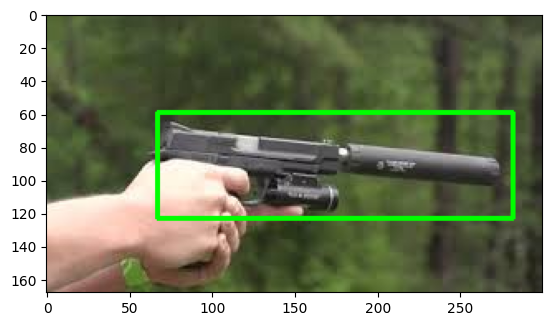

In [11]:
def draw_bounding_box(image_name):
    image = cv2.imread(os.path.join(DATASET_IMAGES_PATH, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'x1'])
    y1 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'y1'])
    x2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'x2'])
    y2 = int(labeled_images_df.loc[labeled_images_df['image_name'] == image_name, 'y2'])
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()

draw_bounding_box(labeled_images_df['image_name'][314])

In [12]:
labeled_images_df.drop('label_name', inplace=True, axis=1)
labeled_images_df.columns

Index(['image_name', 'count', 'x1', 'y1', 'x2', 'y2'], dtype='object')

In [13]:
labeled_images_df.drop('count', inplace=True, axis=1)
labeled_images_df.columns

Index(['image_name', 'x1', 'y1', 'x2', 'y2'], dtype='object')

## Konfiguracja

In [34]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 16
IMG_AVG_WIDTH = 300
IMG_AVG_HEIGH = 170

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

## Podział csv na train i val

In [15]:
train_df, valid_df = train_test_split(labeled_images_df, test_size = 0.15, random_state = 42)

## Augmentacja obrazów

In [16]:
train_augs = A.Compose([
    A.Resize(IMG_AVG_HEIGH,IMG_AVG_WIDTH),
    A.HorizontalFlip(p=0.5),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_AVG_HEIGH,IMG_AVG_WIDTH)
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

## Przygotowanie pliku CSV do wprowadzenia do modelu

In [17]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    x1 = row.x1
    y1 = row.y1
    x2 = row.x2
    y2 = row.y2

    bbox = [[x1,y1,x2,y2]]

    img = cv2.imread(os.path.join(DATASET_IMAGES_PATH, row['image_name']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1)/ 255.0
    bbox = torch.Tensor(bbox)

    return img, bbox

In [21]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [22]:
df = validset.df
df = df.drop(301)
validset = ObjLocDataset(df, valid_augs)

In [23]:
print(f"trainset : {len(trainset)}")
print(f"validset : {len(validset)}")

trainset : 283
validset : 49


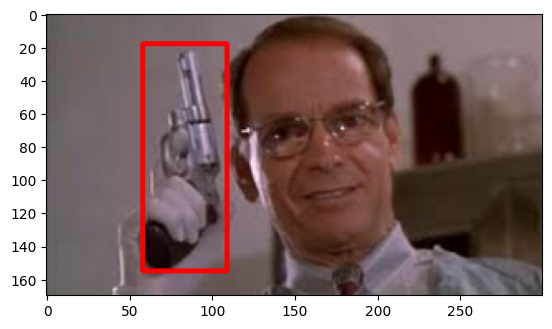

In [25]:
img, bbox = validset[0]

x1, y1, x2, y2 = bbox

pt1 = (int(x1), int(y1))
pt2 = (int(x2), int(y2))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)

bnd_img = np.clip(bnd_img, 0, 1)

bnd_img = (bnd_img * 255).astype(np.uint8)

plt.imshow(bnd_img)

## Utworzenie wsadów

In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [27]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 18
Total no. batches in validloader : 4


In [31]:
for images, bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 170, 300])
Shape of one batch bboxes : torch.Size([16, 4])


## Utworzenie modelu

In [32]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [35]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [36]:
random_img = torch.rand(1,3,170,300).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

## Trenowanie modelu

In [37]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [38]:
def eval_fn(model, dataloader):
  total_loss =0.0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [40]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Zapisano wagi")
    best_valid_loss = valid_loss

  print(f"Epoch : {i + 1} train loss : {train_loss} valid loss : {valid_loss}")

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 1 train loss : 11913.222059461805 valid loss : 1987.1453552246094


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 2 train loss : 7094.729465060764 valid loss : 5190.825500488281


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 3 train loss : 5446.066569010417 valid loss : 4584.4495849609375


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 4 train loss : 3981.8406846788193 valid loss : 5125.126708984375


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 5 train loss : 3318.2796427408853 valid loss : 3347.6820678710938


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 6 train loss : 2279.8119913736978 valid loss : 1478.4843139648438


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 7 train loss : 1827.5625339084202 valid loss : 1839.7789001464844


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 8 train loss : 1290.5485229492188 valid loss : 1933.4054260253906


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 9 train loss : 914.200915866428 valid loss : 1138.7620544433594


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 10 train loss : 929.4783155653212 valid loss : 1097.941177368164


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 11 train loss : 629.3025970458984 valid loss : 1175.169189453125


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 12 train loss : 526.8104671902126 valid loss : 875.9378776550293


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 13 train loss : 485.23157585991754 valid loss : 799.169620513916


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 14 train loss : 435.7719955444336 valid loss : 758.3966217041016


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 15 train loss : 352.716670566135 valid loss : 773.231819152832


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 16 train loss : 350.46666463216144 valid loss : 696.109489440918


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 17 train loss : 343.7170571221246 valid loss : 590.4328126907349


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 18 train loss : 289.25574747721356 valid loss : 783.0486145019531


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 19 train loss : 284.87205759684247 valid loss : 704.9195709228516


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 20 train loss : 271.0135896470812 valid loss : 652.6125907897949


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 21 train loss : 271.48244603474933 valid loss : 608.0409355163574


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 22 train loss : 212.60504319932727 valid loss : 712.2777557373047


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 23 train loss : 221.06237114800348 valid loss : 684.3382606506348


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Zapisano wagi
Epoch : 24 train loss : 235.11613972981772 valid loss : 529.1452579498291


  0%|          | 0/18 [00:00<?, ?it/s]